# Project 4 - Sentiment Analysis for Mental Health

In recent years, the intersection of data science and mental health has emerged as a powerful space for innovation, particularly with the growing availability of natural language data. From social media posts to clinical transcripts, the language people use can offer deep insights into their emotional well-being, cognitive states, and potential mental health conditions. Natural Language Processing (NLP) enables researchers and practitioners to systematically analyze these text-based signals at scale, uncovering patterns that may not be immediately evident to human observers.

This project explores the use of NLP techniques for mental health analysis using a composite dataset curated from multiple sources available on Kaggle. The dataset integrates user-generated content, survey responses, and annotated mental health indicators to form a rich foundation for multi-faceted analysis. By combining diverse data types and origins, the project aims to evaluate how effectively machine learning models can identify signs of depression, anxiety, stress, and other mental health concerns through linguistic features.

The goals of this exploration include preprocessing and unifying heterogeneous text data, applying modern NLP techniques (such as sentiment analysis, topic modeling, and transformer-based embeddings), and training classifiers to predict mental health status. Ultimately, this work aims to contribute to the growing body of research on how data-driven tools can support early detection and intervention in mental health care, while also surfacing ethical considerations around privacy, bias, and the responsible use of AI in sensitive domains.

## Model Tuning

The dataset selected came pre-cleaned and preprocessed. It had only two columns - a text sample and our target variable. As such, we did not include any files explaining the EDA, Cleaning, or Preprocessing steps.

In order to properly evaluate and tune our models, we used cross-validation over training/testing splits of the data. 

The primary metric used is recall to emphasize minimizing false negatives.


## Models Evaluated

- [Logistic Regression](#logistic-regression)
- [XGBoost](#xgboost)
- [Naive Bayes](#naive-bayes)
- [BERT Classification](Production%20Model.ipynb)

### Introduction

**Imports**

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# SKLearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score

# XGBoost
from xgboost import XGBClassifier

**Methods**

In [2]:
def evaluate(model):
    """Prints various evaluation metrics.

    Evaluates accuracy score for both training and testing data as well as the recall score of the test set.

    Args:
        model: sklearn model to evaluate
    """
    print(f'Train: {model.score(X_train, y_train)}')
    print(f'Test: {model.score(X_test, y_test)}')
    print(f'Recall: {recall_score(y_test, model.predict(X_test))}')

**Load and prepare data**

In [3]:
df = pd.read_csv('../data/sentiment.csv').drop(columns='Unnamed: 0')

**Train/Test Split**

In [21]:
X = df['statement'].astype(str)
y = df['status'].map({'Normal': 0}).fillna(1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Models

#### Logistic Regression

In [ ]:
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(max_features=None, stop_words=None)),
    ('lr', LogisticRegression(random_state=42))
])

params = {
    'cvec__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'cvec__max_df': (0.5, 0.75, 1.0),
    'cvec__min_df': (0.01, 0.1, 0.2)
}

cvec_grid = GridSearchCV(cvec_pipe,
                         params,
                         n_jobs=-1,
                         cv=5)

cvec_grid.fit(X_train, y_train)

evaluate(cvec_grid)

In [32]:
coef_df = pd.DataFrame(cvec_grid.best_estimator_[1].coef_[0], 
                       columns=['coef'], 
                       index=cvec_grid.best_estimator_[0].get_feature_names_out()).sort_values(ascending=False, by='coef')

coef_df['coef'] = np.exp(coef_df['coef'])

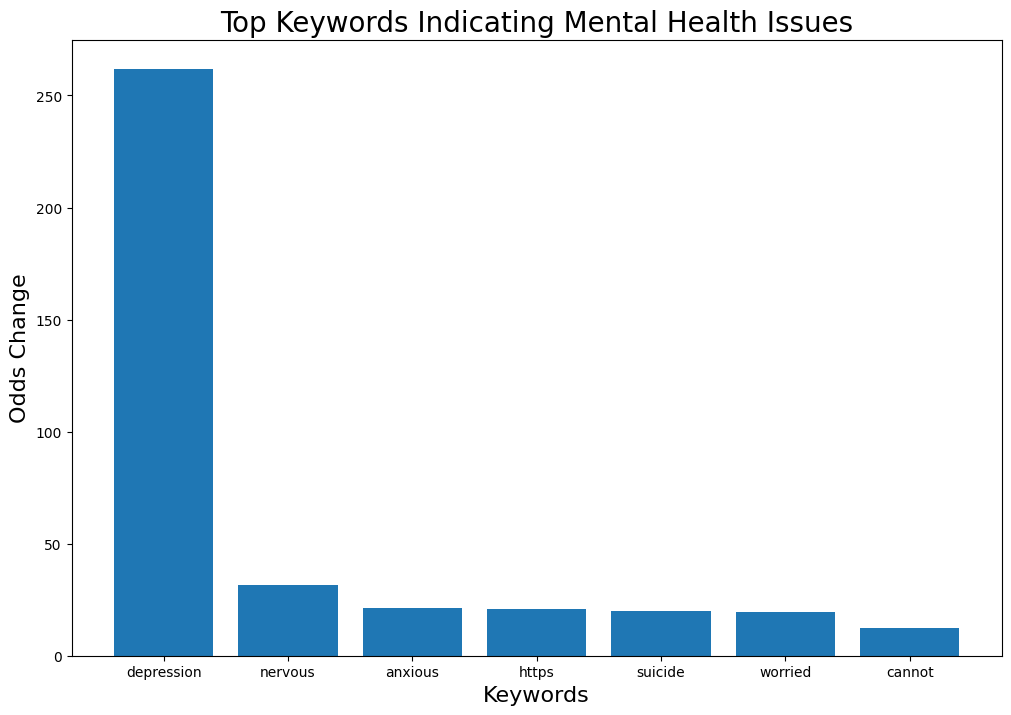

In [43]:
plt.figure(figsize=(12,8))

plt.bar(coef_df.head(7).index, coef_df.head(7)['coef'])
plt.title('Top Keywords Indicating Mental Health Issues', size=20)
plt.xlabel('Keywords', size=16)
plt.ylabel('Odds Change', size=16)
plt.savefig('../images/keywords.png');

#### XGBoost

In [ ]:
xgb_pipe = Pipeline([
    ('cvec', CountVectorizer(max_features=None, stop_words=None)),
    ('xgb', XGBClassifier())
])

params = {
    'cvec__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'cvec__max_df': (0.5, 0.75, 1.0),
    'cvec__min_df': (0.01, 0.1, 0.2)
}

xgb_grid = GridSearchCV(xgb_pipe,
                         params,
                         n_jobs=-1,
                         cv=5)

xgb_grid.fit(X_train, y_train)

evaluate(xgb_grid)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'cvec__max_df': (0.5, ...), 'cvec__min_df': (0.01, ...), 'cvec__ngram_range': ((1, ...), ...)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


#### Naive Bayes

In [19]:
nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__min_df': (1, 5, 10),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'nb__fit_prior': [True, False]
}

nb_grid = GridSearchCV(nb_pipe,
                       params,
                       n_jobs=-1,
                       cv=5)

nb_grid.fit(X_train, y_train)

evaluate(nb_grid)

Train: 0.9544768991000955
Test: 0.9126762687580122
Recall: 0.7930528375733855
